# Simulating forced choice tasks in ExemPy

ExemPy is built to simulate the types of tasks that are often used in speech perception experiments. This allows to more directly compare simulated results with behavior.

In ExemPy-Basics, we simulated an identifcation task, in which the "perceiver" provides a label from multiple options. This allowed us to produce a confusion matrix. 

Simulating a two-alternative forced choice (2AFC) task allows us to produce the type of plot often used to demonstrate categorical perception. 

In this section we'll
1. Create a continuum interpolated from one vowel to another
2. Categorize that continuum
3. Introduce considerations for simulating forced choice
4. Visualize forced choice results
5. Repeat the process with additional continua
6. Analyze the graph

In [1]:
%load_ext autoreload
from ExemPy import *
from ExemPy.utils import *
from ExemPy.viz import *
from ExemPy.GCM import *
%aimport ExemPy, ExemPy.utils, ExemPy.viz, ExemPy.GCM
%autoreload 1
import math
import random
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy.optimize import minimize
import seaborn as sns
sns.set(style='ticks', context='paper')
colors=["#e3c934","#68c4bf","#c51000","#287271"]
sns.set_palette(colors)

## Set up data
- Read in Peterson and Barney 1952
- Convert Hz to Bark
- Preview pb52
- Set parameters for preliminary categorization

In [2]:
pb52 = pd.read_csv('pb52_data//pb52.csv')
pb52 = HzToBark(pb52,["F0", "F1", "F2", "F3"])
excloud = pb52.copy()
pb52.sample(5)

,type,gender,speaker,vowel,repetition,F0,F1,F2,F3,z0,z1,z2,z3
238,m,m,12,NURSE,1,125,400,1450,1650,1.077314,4.014068,10.870147,11.723878
211,m,m,11,PALM,2,131,746,1018,2300,1.149632,6.861079,8.634735,13.944883
1448,c,f,73,STRUT,1,290,700,1730,2960,2.925511,6.525263,12.039458,15.599593
267,m,m,14,TRAP,2,109,750,1710,2440,0.882417,6.889742,11.961853,14.337364
759,w,f,38,NURSE,2,197,493,1930,2300,1.918572,4.858231,12.771620,13.944883


In [3]:
dimsvals = {'z0' : 1,
            'z1' : .761,
            'z2' : .681,
            'z3' : .407}
dimslist = list(dimsvals.keys())
catslist = ['type', 'vowel']           # man, woman, or child; lexical set notation
cval = 25

## Create type m continuum

### Get mean dimensions for each type x vowel combination

In [4]:
datasumm = datasummary(pb52, catslist, dimslist)
print("Type 'm' formant averages (Bark) by vowel:")
datasumm[datasumm["type"] == "m"]

Type 'm' formant averages (Bark) by vowel:


,type,vowel,z0,z1,z2,z3
10,m,DRESS,1.116743,5.132435,12.491891,14.438514
11,m,FLEECE,1.207534,2.674882,13.914472,15.535502
12,m,FOOT,1.208595,4.347787,8.636553,13.766756
13,m,GOOSE,1.247804,3.093098,7.695949,13.727507
14,m,KIT,1.204788,3.931608,12.975164,14.668190
15,m,NURSE,1.168517,4.807455,10.439210,11.939155
16,m,PALM,1.061577,6.653223,9.038935,14.315383
17,m,STRUT,1.118489,5.989758,9.588147,14.146945
18,m,THOUGHT,1.100155,5.484137,7.457763,14.207406
19,m,TRAP,1.073975,6.240755,12.013320,14.270487


### Create a FOOT-STRUT continuum using m values

In [5]:
start = {"type" : "m", "vowel" : "FOOT"}      # Step 1
end = {"type" : "m", "vowel" : "STRUT"}      # Step n
steps = 7      # Number of steps in continuum

mcont = continuum(datasumm,      # dataframe for starting values
                 start, 
                 end, 
                 dimslist, 
                 steps, 
                 stimdetails = True      # Print details of the endpoints
                ) 
mcont

Start:  index           12
type             m
vowel         FOOT
z0        1.208595
z1        4.347787
z2        8.636553
z3       13.766756
Name: 0, dtype: object
End:  index           17
type             m
vowel        STRUT
z0        1.118489
z1        5.989758
z2        9.588147
z3       14.146945
Name: 0, dtype: object


,step,z0,z1,z2,z3
0,1,1.208595,4.347787,8.636553,13.766756
1,2,1.193577,4.621449,8.795152,13.830121
2,3,1.178560,4.895111,8.953751,13.893486
3,4,1.163542,5.168773,9.112350,13.956851
4,5,1.148524,5.442435,9.270949,14.020215
5,6,1.133507,5.716097,9.429548,14.083580
6,7,1.118489,5.989758,9.588147,14.146945


## What does forced choice mean for perception?

During a forced choice task, an experiment participant is, well, forced to choose between two options. Often, these choices are two clear endpoints of an interpolated continuum like the one we just created. 

But what does it mean for a perceiver to know that they'll have to pick between two choices?

At this time, I identify three, non mutually exclusive vectors for modelling the "side effects" of a forced choice task. These occur at two different levels: the level of perception and the level of deciding how to respond. 

My thinking about this dinstinction is heavily influenced by Zheng and Samuel's (2017) problematization of *perception* vs *interpretation*. I need to re-read the paper to decide/interpret whether I'm using the word decision is a different way than they use interpretation. To be honest, I definitely thought they had said "decide" until I looked up the citation. It almost feels like a "below vs above the level of consciousness" situation.

**1. At the level of perception** (implemented during the `activation()` function)
- Base activation *N*: The expectation within the experiment is that the percept will be one of two options. Activation may be raised for the alternatives and quashed for would-be competitors in a straightforward example of priming.
- Attention weights *w*: 

**2. At the level of decision** (implemented during the `choose()` function)
- Rather than choosing the label with the highest probability overall, the 'perceiver' chooses the alternative with the higher probability of the two

The argument `fc = {<category type> : [<label>, <label>, ...]}` implements forced choice at the level of decision. Probabilities for the category type given are calculated as usual, but the choices are restricted to the options given. 

It's tempting to see the `activation()` function as 'perception' and the `choose()` function as interpretation. At every step, I think we should be explicit about the following: Something making the implementation possible, or being possible in the implementation, does not imply the analog in language users' perception or interpretation.   

## Categorize continuum with respect to pb52 



In [6]:
terms = {"vowel" : ["FOOT", "STRUT"]}

In [7]:
choices_mcont = multicat(
    mcont,
    excloud,
    catslist,
    dimsvals,
    cval,
    exclude_self = True,
    N = 1,
    fc = terms)
choices_mcont

,step,z0,z1,z2,z3,typeChoice,typeProb,vowelChoice,vowelProb
0,1,1.208595,4.347787,8.636553,13.766756,m,0.998427,FOOT,0.975880
1,2,1.193577,4.621449,8.795152,13.830121,m,0.998456,FOOT,0.994435
2,3,1.178560,4.895111,8.953751,13.893486,m,0.998329,FOOT,0.972424
3,4,1.163542,5.168773,9.112350,13.956851,m,0.995452,STRUT,0.555092
4,5,1.148524,5.442435,9.270949,14.020215,m,0.998454,STRUT,0.978905
5,6,1.133507,5.716097,9.429548,14.083580,m,0.999070,STRUT,0.976005
6,7,1.118489,5.989758,9.588147,14.146945,m,0.999296,STRUT,0.943317


### Categorical perception plot

The plot below shows the results of our simulated 2AFC identification task. On the X-axis is the continuum from FOOT (step 1) to STRUT (step 7). On the Y-axis is the probability of categorization as FOOT (rather than STRUT), which is taken as analagous to the proportion of FOOT responses in an experiment. 

A dotted line is printed at 0.5, or roughly chance. Above this line, "FOOT" is a more likely response than "STRUT". We can consider the point along the continuum at which the curve crosses this line as the boundary between "FOOT" and "STRUT".

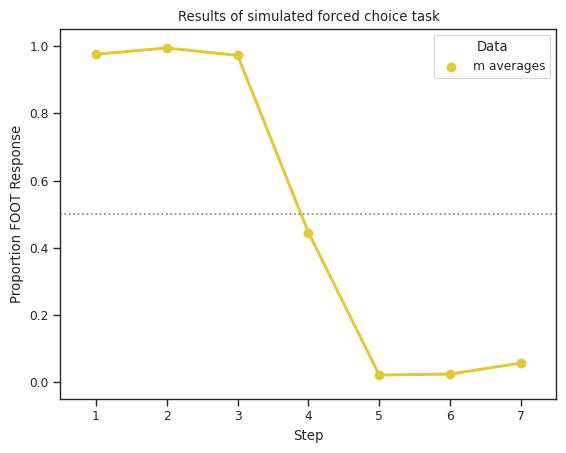

In [8]:
p = cpplot(datalist = choices_mcont,
           cat = "vowel",
           xax = "step",
           datanames = ["m averages"]
          )
p.set(title = "Results of simulated forced choice task")
plt.show()

## Repeat this process with average woman values

Repeating the process with the average woman values demonstrates the need for care and transparency in how the "forced choice" aspect of the text is simulated. 

For the man continuum, the probability was always above 0.5. For the w values, this won't be the case.

In [9]:
start = {"type" : "w", "vowel" : "FOOT"}      # Step 1
end = {"type" : "w", "vowel" : "STRUT"}      # Step n
steps = 7      # Number of steps in continuum

wcont = continuum(datasumm, start, end, dimslist, steps, stimdetails = False) 

choices_wcont = multicat(
    wcont,
    excloud,
    catslist,
    dimsvals,
    cval,
    exclude_self = True,
    N = 1,
    fc = terms)
choices_wcont

,step,z0,z1,z2,z3,typeChoice,typeProb,vowelChoice,vowelProb
0,1,2.32341,4.636707,9.405672,14.947067,w,0.958173,FOOT,0.974100
1,2,2.30292,5.019998,9.615083,14.981178,w,0.977810,FOOT,0.992542
2,3,2.28243,5.403288,9.824495,15.015290,w,0.980696,FOOT,0.607590
3,4,2.26194,5.786579,10.033906,15.049401,w,0.960333,FOOT,0.280120
4,5,2.24145,6.169870,10.243318,15.083513,w,0.961737,STRUT,0.767191
5,6,2.22096,6.553161,10.452729,15.117624,w,0.990411,STRUT,0.994830
6,7,2.20047,6.936452,10.662141,15.151736,w,0.983766,STRUT,0.994342


At step 4, there is only a 0.28 probability that the vowel will be classified as FOOT. Although we expect to see uncertainty at the most ambiguous point along the continuum, this is an unusually low value for any winning category label.

In fact, PALM, not FOOT, was the label with the highest probability. To see this, let's turn off the forced choice parameter with `fc = None` (or by simply not providing the argument). 


In [10]:
choices_wcont_2 = multicat(
    wcont,
    excloud,
    catslist,
    dimsvals,
    cval,
    exclude_self = True,
    N = 1,
    fc = None)      # Turn off the forced choice terms
choices_wcont_2

,step,z0,z1,z2,z3,typeChoice,typeProb,vowelChoice,vowelProb
0,1,2.32341,4.636707,9.405672,14.947067,w,0.958173,FOOT,0.974100
1,2,2.30292,5.019998,9.615083,14.981178,w,0.977810,FOOT,0.992542
2,3,2.28243,5.403288,9.824495,15.015290,w,0.980696,FOOT,0.607590
3,4,2.26194,5.786579,10.033906,15.049401,w,0.960333,PALM,0.624499
4,5,2.24145,6.169870,10.243318,15.083513,w,0.961737,STRUT,0.767191
5,6,2.22096,6.553161,10.452729,15.117624,w,0.990411,STRUT,0.994830
6,7,2.20047,6.936452,10.662141,15.151736,w,0.983766,STRUT,0.994342


----- Hey! -----
Stimulus 4
in dataset fc off
was categorized as PALM
with probability 0.62


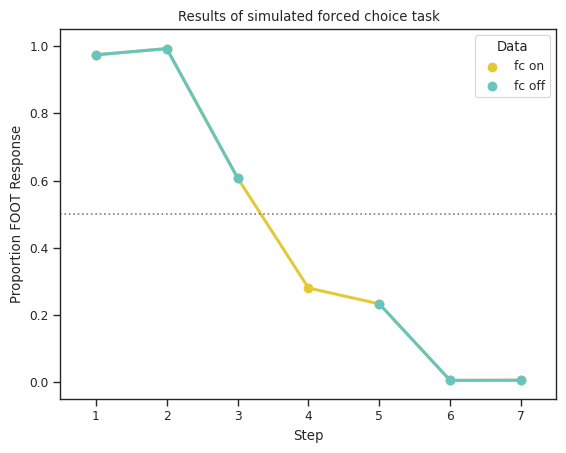

In [11]:
p = cpplot([choices_wcont, choices_wcont_2],
           "vowel",
           xax = "step",
           datanames = ["fc on", "fc off"])
p.set(title = "Results of simulated forced choice task")
plt.show()

## Repeat the process for all 3 types
Next

In [12]:
continuum_is = {"vowel" : ["FOOT", "STRUT"]}
grouping = {"type" : ["w", "c", "m"]}
steps = 7
dimsvals = {'z0' : 1,
            'z1' : .761,
            'z2' : .681,
            'z3' : .407}
dimslist = list(dimsvals.keys())
catslist = ['vowel']
cval = 25
excloud = pb52.copy()

----- Hey! -----
Stimulus 4
in dataset w
was categorized as PALM
with probability 0.62


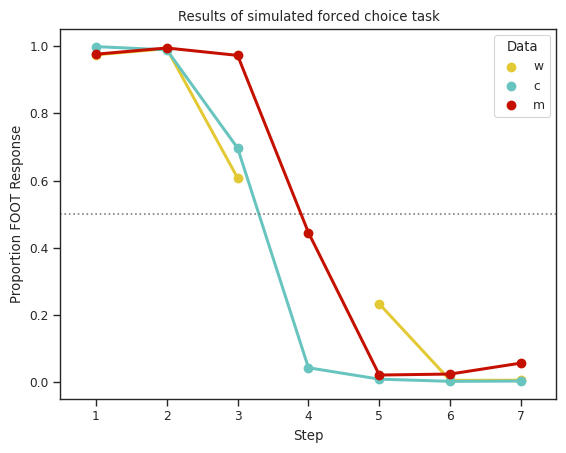

In [13]:
# unpack variables
contcat = list(continuum_is.keys())[0]
start = continuum_is[contcat][0]
end = continuum_is[contcat][1]
groupingcat = list(grouping.keys())[0]
labellist = grouping[groupingcat]

datsumm = datasummary(excloud, ['type','vowel'], dimslist)
datalist = []

for l in labellist:
    # get start and end rows
    strt = {contcat : start, groupingcat : l}
    nd = {contcat : end, groupingcat : l}
    # make continuum
    cnt = continuum(datsumm, strt, nd, dimslist, steps = steps)
    # make choices
    chs = multicat(cnt, excloud, catslist, dimsvals, cval,
                  exclude_self = True, N = 1, fc = None)
    datalist.append(chs)

p = cpplot(datalist = datalist,
           cat = "vowel",
           xax = "step",
           datanames = labellist)
p.set(title = "Results of simulated forced choice task")
plt.show()

### And let's visualize the continua for good measure 

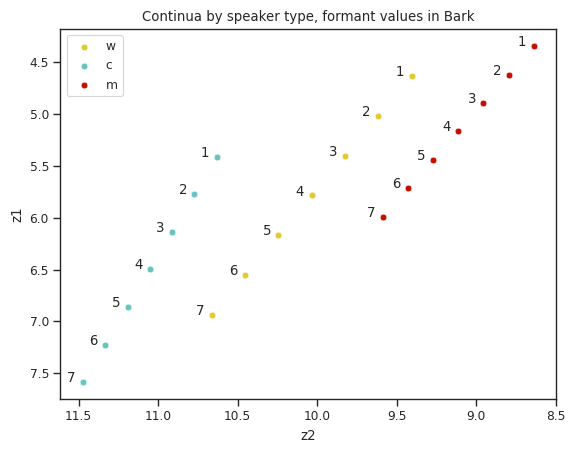

In [14]:
labix = 0
for d in datalist:
    # get the name of the dataset
    lab = labellist[labix]
    pl = sns.scatterplot(x = 'z2', y = 'z1', data = d, label = lab)
    # Label points
    for line, row in d.iterrows():
        pl.text(d['z2'][line]+0.1, d['z1'][line], d['step'][line])
    labix += 1
pl.invert_yaxis()
pl.invert_xaxis()
plt.title("Continua by speaker type, formant values in Bark")
plt.show()